In [13]:
%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [131]:
from plotutils.plotutils import *
plt.style.use('plotutils/kevin.mplstyle')
import seaborn as sns

from glob import glob 
from pathlib import Path 
from fastcore.xtras import load_pickle, save_pickle
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from umap import UMAP 
from xgboost import XGBClassifier

import numpy as np

from shap import TreeExplainer

from pycm import ConfusionMatrix

In [15]:
labels = pd.read_csv('../data/Cement_Storage_UK_TSA.csv')

In [16]:
labels_2 = pd.read_csv('../data/Material_KPIs_cement.csv')

In [17]:
all_features = glob('../data/features/*.csv')

In [18]:
ph_images = glob('../data/ph_feat_new_2/*.csv')

In [19]:
loaded_feat = []

for feat in all_features:
    name = Path(feat).stem 
    feat = pd.read_csv(feat)
    feat['name'] = name
    loaded_feat.append(feat)

In [20]:
ph_images_feat = []

for ph in ph_images: 
    name = Path(ph).stem 
    feat = pd.read_csv(ph)
    feat['name'] = name
    ph_images_feat.append(feat)

In [21]:
all_features = pd.concat(loaded_feat)
del all_features['Unnamed: 0']

In [22]:
ph_images_feat = pd.concat(ph_images_feat)

In [23]:
features = [f for f in ph_images_feat.columns if 'ph' in f]
no_ph_features = [f for f in all_features.columns if f not in features]

In [24]:
joined_feat = pd.merge(
    ph_images_feat[features + ['name']], 
    all_features[no_ph_features], 
    left_on='name', 
    right_on='name'
)

In [25]:
all_features = joined_feat

In [26]:
feature_names = list(set(all_features.columns) - set(['name']))

In [132]:
save_pickle('../data/feature_names.pkl', feature_names)

In [27]:
all_data = pd.merge(all_features, labels, left_on='name', right_on='MOF')

In [28]:
all_data = pd.merge(all_data, labels_2, left_on='name', right_on='MOF')

## Now, get the benchmark CAC

In [34]:
import scipy.interpolate as sp_int

MEA_nCAC_cem = 106.79148976385494  # €/tCO2
MEA_recovery_cem = 90  # %

data_CAC_cem = {'recovery': [90, 95, 99, 99.71, 99.93, 99.95],
                'CAC_lit': [65, 65.5, 67.6, 69.1, 73.4, 74.1]} # for coal taken from https://doi.org/10.1016/j.ijggc.2021.103473 Figure 6

CAC_interp_cem = sp_int.interp1d(data_CAC_cem['recovery'], data_CAC_cem['CAC_lit'], fill_value='extrapolate')
df_MEA_CAC_cem_TSA = MEA_nCAC_cem * CAC_interp_cem(labels['recovery']) / data_CAC_cem['CAC_lit'][0]

In [133]:
below_benchmark = []

for i, row in all_data.iterrows(): 
    if row['nCAC'] > 0:
        if row['nCAC'] < df_MEA_CAC_cem_TSA[i]:
            below_benchmark.append(True)
        else:
            below_benchmark.append(False)
    else:
        below_benchmark.append(False)
all_data['below_benchmark'] = below_benchmark

In [134]:
all_data['below_water_benchmark'] = all_data['water_resistance'] < 0.7

In [135]:
subset = all_data[all_data['below_benchmark'] == True]

In [136]:
subset['below_water_benchmark'].value_counts()

below_water_benchmark
True     317
False     67
Name: count, dtype: int64

In [137]:
all_data.to_pickle('../data/all_data.pkl')

## Build an initial model

### nCAC

In [138]:
train, test = train_test_split(all_data, train_size=.7, stratify=all_data['below_benchmark'])

In [139]:
ph_features = [f for f in feature_names if 'ph' in f]

In [140]:
model = XGBClassifier(n_estimators=1000, max_depth=5, n_jobs=-1)

In [141]:
model.fit(train[feature_names], train['below_benchmark'].astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [142]:
predictions = model.predict(test[feature_names])

In [143]:
predictions

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1])

In [144]:
cm = ConfusionMatrix(test['below_benchmark'].values.astype(int), predictions)

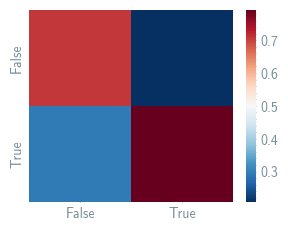

In [145]:
sns.heatmap(pd.DataFrame(cm.normalized_table), cmap='RdBu_r')
plt.xticks([0.5,1.5], ['False', 'True'])
plt.yticks([0.5,1.5], ['False', 'True'])

plt.savefig('confusion_matrix_below_benchmark.pdf', bbox_inches='tight')

In [146]:
print(cm)

Predict  0        1        
Actual
0        65       27       

1        24       92       





Overall Statistics : 

95% CI                                                            (0.69634,0.81327)
ACC Macro                                                         0.75481
ARI                                                               0.25603
AUNP                                                              0.74981
AUNU                                                              0.74981
Bangdiwala B                                                      0.57698
Bennett S                                                         0.50962
CBA                                                               0.73982
CSI                                                               0.50154
Chi-Squared                                                       52.31917
Chi-Squared DF                                                    1
Conditional Entropy                                          

### Water resistance 

In [147]:
train, test = train_test_split(subset, train_size=.7, stratify=subset['below_water_benchmark'])

In [148]:
model_water = XGBClassifier(n_estimators=1000, max_depth=5, n_jobs=-1,  scale_pos_weight=69/321)

In [149]:
model_water.fit(train[features], train['below_water_benchmark'].astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [150]:
predictions_water = model_water.predict(test[features])

In [151]:
cm_water = ConfusionMatrix(test['below_water_benchmark'].values.astype(int), predictions_water)

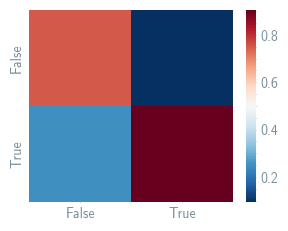

In [152]:
sns.heatmap(pd.DataFrame(cm_water.normalized_table), cmap='RdBu_r')
plt.xticks([0.5,1.5], ['False', 'True'])
plt.yticks([0.5,1.5], ['False', 'True'])

plt.savefig('confusion_matrix_water.pdf', bbox_inches='tight')

In [153]:
print(cm_water)

Predict  0        1        
Actual
0        15       5        

1        9        87       





Overall Statistics : 

95% CI                                                            (0.82003,0.93859)
ACC Macro                                                         0.87931
ARI                                                               0.50014
AUNP                                                              0.82812
AUNU                                                              0.82812
Bangdiwala B                                                      0.83698
Bennett S                                                         0.75862
CBA                                                               0.76562
CSI                                                               0.61345
Chi-Squared                                                       43.4409
Chi-Squared DF                                                    1
Conditional Entropy                                           